### Michelle Helfman - Forecasting Natural Gas Prices.

#  Milestone 3 - Code for Analysis

## Data Exploration and Visualizations

In [1]:
# Import Functions
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import datetime
import pmdarima as pm

from datetime import date
from math import sqrt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set your custom color palette

colors = ["#FF0B04", "#3355FF", "#782F98","#00FF00"]
mf_colors = ["#3355FF", "#FF0B04"]
more_colors = ["#FF0B04", "#3355FF", "#FF7733", "#782F98", "#00FF00","#FFFF4D","#D2691E"]
cust_colors = sns.set_palette(sns.color_palette(colors))
red = "#FF0B04"
pastel_red = '#FF6666'
blue = "#3355FF"
purple = "#782F98"

In [3]:
# Create data frame for Natural Gas Pricing records
ng_df = pd.read_csv('Natural Gas Prices.csv')

# Create data frame for Winter Cross-Reference records
winter_df = pd.read_csv('Winter Dates.csv')

# Change Close/Last column header to Close
new_col_headers = {'Close/Last': 'Close'}
ng_df.rename(columns = new_col_headers, inplace = True)

# Convert Date to Price Date (datetime)
ng_df['Price Date'] = pd.to_datetime(ng_df['Date'])

print('1st 10 Rows of Natural Gas Prices Dataset')
ng_df.head(10)

1st 10 Rows of Natural Gas Prices Dataset


,Date,Close,Volume,Open,High,Low,Price Date
0,7/24/2024,2.117,60124,2.153,2.170,2.102,2024-07-24
1,7/23/2024,2.187,101886,2.245,2.265,2.123,2024-07-23
2,7/22/2024,2.251,136869,2.104,2.270,2.090,2024-07-22
3,7/19/2024,2.128,96794,2.089,2.143,2.057,2024-07-19
4,7/18/2024,2.125,143006,2.047,2.134,2.024,2024-07-18
5,7/17/2024,2.035,193517,2.181,2.208,2.015,2024-07-17
6,7/16/2024,2.188,120740,2.170,2.218,2.149,2024-07-16
7,7/15/2024,2.158,177756,2.273,2.285,2.147,2024-07-15
8,7/12/2024,2.329,120501,2.267,2.350,2.249,2024-07-12
9,7/11/2024,2.268,114135,2.326,2.343,2.261,2024-07-11


In [4]:
ng_df.shape

(2529, 7)

In [5]:
ng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2529 entries, 0 to 2528
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2529 non-null   object        
 1   Close       2529 non-null   float64       
 2   Volume      2529 non-null   int64         
 3   Open        2529 non-null   float64       
 4   High        2529 non-null   float64       
 5   Low         2529 non-null   float64       
 6   Price Date  2529 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 138.4+ KB


In [6]:
# Look for Nulls
null_counts = ng_df.isna().sum()
total = len(ng_df)

print('Percentage Natural Gas Prices Columns with NULLS')
pct_null = round((null_counts / total) * 100,1)
pct_null

Percentage Natural Gas Prices Columns with NULLS


Date          0.0
Close         0.0
Volume        0.0
Open          0.0
High          0.0
Low           0.0
Price Date    0.0
dtype: float64

In [7]:
# Describe the dataset

print("Summary statistics:")
ng_df.describe()

Summary statistics:


,Close,Volume,Open,High,Low
count,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000
mean,3.177888,122625.862001,3.181863,3.261878,3.100961
std,1.396277,58106.548021,1.398163,1.460824,1.335970
min,1.482000,90.000000,1.441000,1.567000,1.432000
25%,2.456000,89638.000000,2.464000,2.530000,2.408000
50%,2.797000,122985.000000,2.803000,2.846000,2.749000
75%,3.250000,156125.000000,3.255000,3.328000,3.188000
max,9.680000,435320.000000,9.817000,10.028000,9.200000


In [8]:
# Create DataFrame for Visualizations

ng_dfv = ng_df.copy()

# Working with dates
ng_dfv['Price Date'] = pd.to_datetime(ng_dfv['Date'])
ng_dfv['Year'] = pd.DatetimeIndex(ng_dfv['Date']).year
ng_dfv['Month'] = pd.DatetimeIndex(ng_dfv['Date']).month
ng_dfv['Month Name'] = pd.DatetimeIndex(ng_dfv['Date']).month_name()
ng_dfv['Year Month'] = ng_dfv['Price Date'].dt.to_period('M')

In [9]:
# Set up Seasons

ng_dfv.loc[(ng_dfv['Month Name'] == 'March') | 
           (ng_dfv['Month Name'] == 'April') | 
           (ng_dfv['Month Name'] == 'May'), 'Season'] = 'Spring'

ng_dfv.loc[(ng_dfv['Month Name'] == 'June') | 
           (ng_dfv['Month Name'] == 'July') | 
           (ng_dfv['Month Name'] == 'August'), 'Season'] = 'Summer'

ng_dfv.loc[(ng_dfv['Month Name'] == 'September') | 
           (ng_dfv['Month Name'] == 'October') | 
           (ng_dfv['Month Name'] == 'November'), 'Season'] = 'Fall'

ng_dfv.loc[(ng_dfv['Month Name'] == 'December') | 
           (ng_dfv['Month Name'] == 'January') | 
           (ng_dfv['Month Name'] == 'February'), 'Season'] = 'Winter'

# Set up winter sort order
ng_dfv.loc[(ng_dfv['Month Name'] == 'December'), 'sort_order'] = 1
ng_dfv.loc[(ng_dfv['Month Name'] == 'January'), 'sort_order'] = 2
ng_dfv.loc[(ng_dfv['Month Name'] == 'February'), 'sort_order'] = 3
           

ng_dfv.head(5)

,Date,Close,Volume,Open,High,Low,Price Date,Year,Month,Month Name,Year Month,Season,sort_order
0,7/24/2024,2.117,60124,2.153,2.170,2.102,2024-07-24,2024,7,July,2024-07,Summer,NaN
1,7/23/2024,2.187,101886,2.245,2.265,2.123,2024-07-23,2024,7,July,2024-07,Summer,NaN
2,7/22/2024,2.251,136869,2.104,2.270,2.090,2024-07-22,2024,7,July,2024-07,Summer,NaN
3,7/19/2024,2.128,96794,2.089,2.143,2.057,2024-07-19,2024,7,July,2024-07,Summer,NaN
4,7/18/2024,2.125,143006,2.047,2.134,2.024,2024-07-18,2024,7,July,2024-07,Summer,NaN


In [10]:
# Seasonal Averages

print("Winter Average Price", ng_dfv['Close'].where(ng_dfv['Season'] == 'Winter').mean())
print("Spring Average Price", ng_dfv['Close'].where(ng_dfv['Season'] == 'Spring').mean())
print("Summer Average Price", ng_dfv['Close'].where(ng_dfv['Season'] == 'Summer').mean())
print("Fall Average Price", ng_dfv['Close'].where(ng_dfv['Season'] == 'Fall').mean())

print("\nWinter Average Volume", ng_dfv['Volume'].where(ng_dfv['Season'] == 'Winter').mean())
print("Spring Average Volume", ng_dfv['Volume'].where(ng_dfv['Season'] == 'Spring').mean())
print("Summer Average Volume", ng_dfv['Volume'].where(ng_dfv['Season'] == 'Summer').mean())
print("Fall Average Volume", ng_dfv['Volume'].where(ng_dfv['Season'] == 'Fall').mean())

Winter Average Price 2.97470819672131
Spring Average Price 2.865326562500001
Summer Average Price 3.275913178294573
Fall Average Price 3.589171924290223

Winter Average Volume 131500.39836065573
Spring Average Volume 116349.38125
Summer Average Volume 113693.48062015504
Fall Average Volume 129510.5094637224


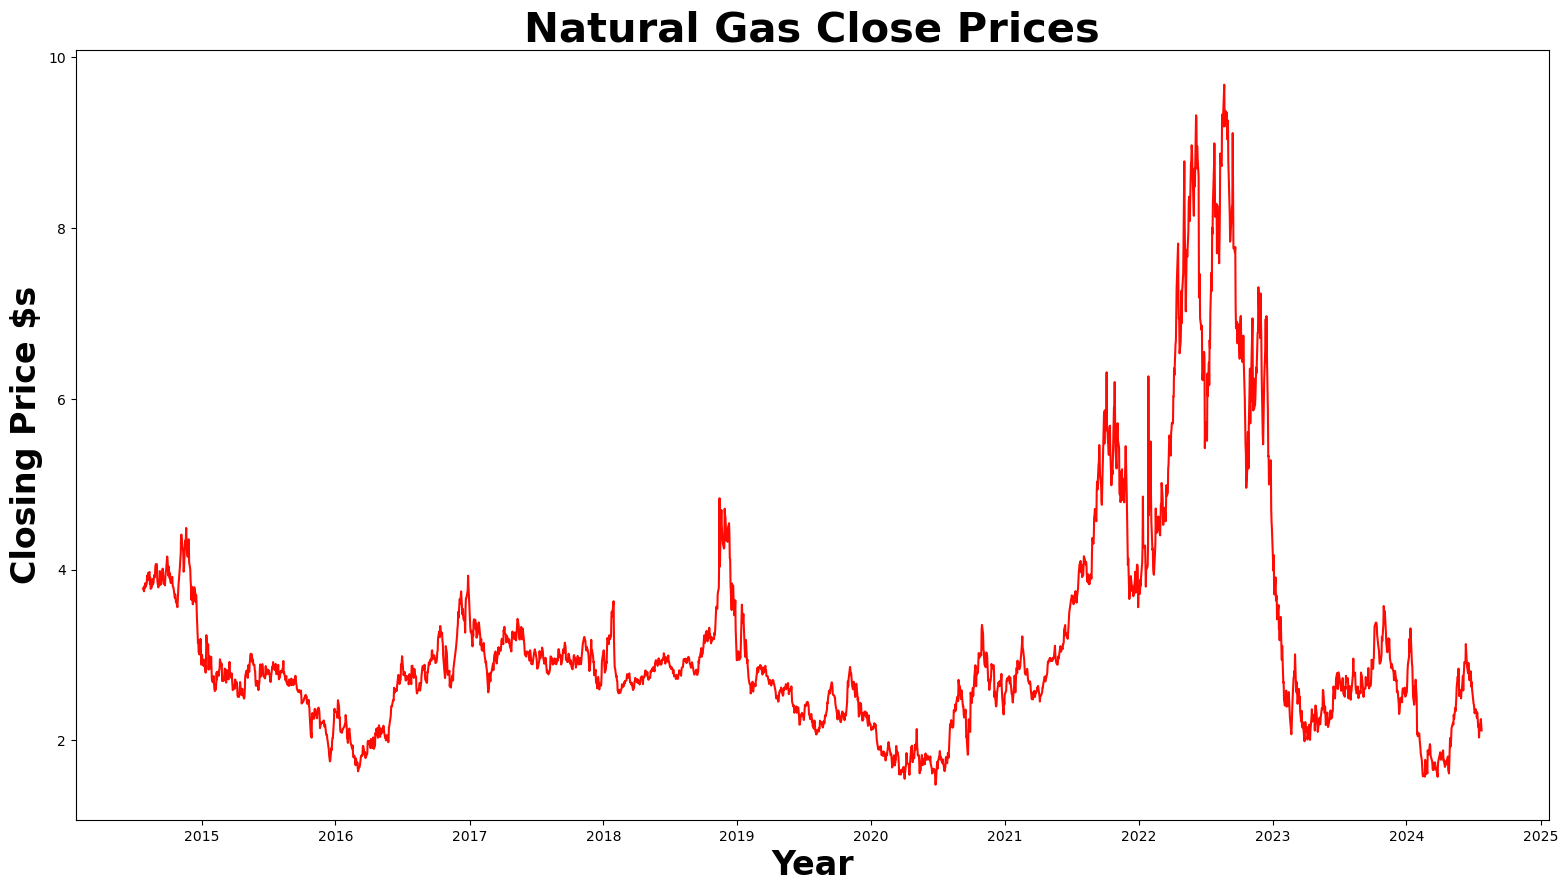

In [11]:
# Plot closing prices

fig, axes = plt.subplots(figsize = (19, 10))

pr_lp = sns.lineplot(x = 'Price Date', y = 'Close', data = ng_dfv,
             palette = more_colors)
pr_lp.set_title('Natural Gas Close Prices', 
                      fontdict={'size': 30, 'weight': 'bold', 'color': 'black'})
pr_lp.set_xlabel('Year', fontdict={'size': 24, 'weight': 'bold'})
pr_lp.set_ylabel('Closing Price $s', fontdict={'size': 24, 'weight': 'bold'})


plt.show()

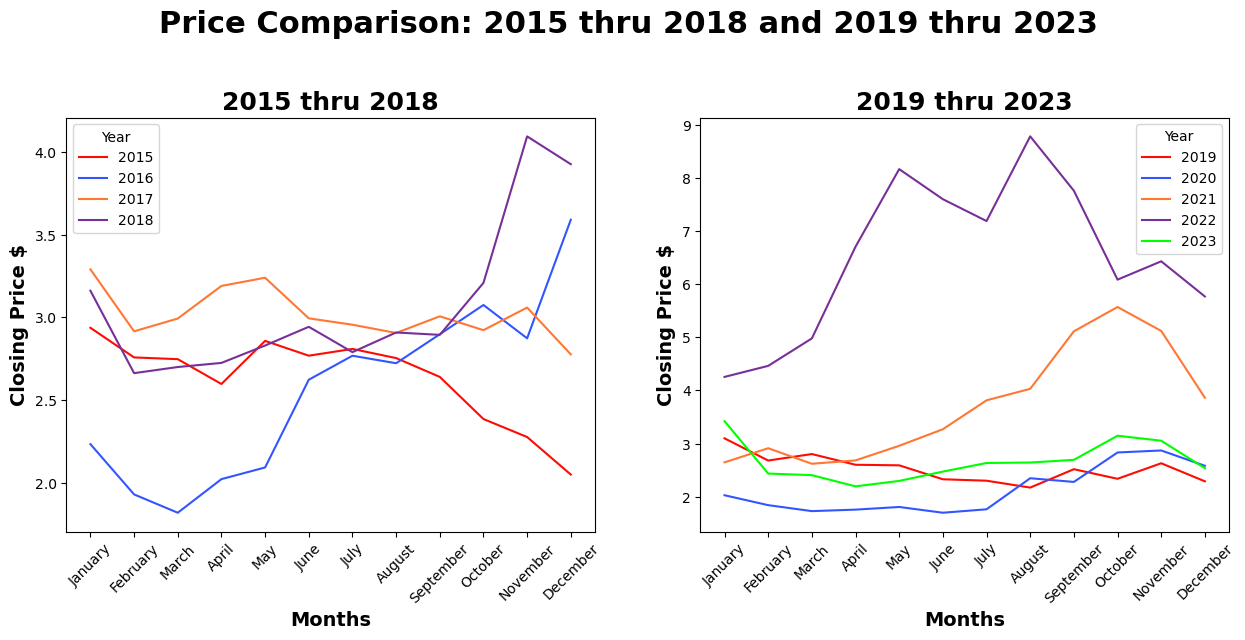

In [12]:
# Side by side view of Annual Prices
plt.figure(figsize=(15,6))

# 1st 4 years of prices
plt.subplot(121)
vs_lp1 = sns.lineplot(x='Month Name', y='Close',  hue='Year',
             data = ng_dfv.loc[(ng_dfv['Year'] >= 2015) & (ng_dfv['Year'] < 2019)].sort_values(by = 'Price Date'),
                     ci = None,
                     palette = more_colors)

vs_lp1.set_title('2015 thru 2018', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vs_lp1.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vs_lp1.set_ylabel('Closing Price $', fontdict={'size': 14, 'weight': 'bold'})
plt.xticks(rotation = 45)

# 2nd 5 years of prices
plt.subplot(122)
vs_lp1 = sns.lineplot(x='Month Name', y='Close',  hue='Year',
             data = ng_dfv.loc[(ng_dfv['Year'] >= 2019) & (ng_dfv['Year'] < 2024)].sort_values(by='Price Date'),
                     ci = None,
                     palette = more_colors)

vs_lp1.set_title('2019 thru 2023', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vs_lp1.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vs_lp1.set_ylabel('Closing Price $', fontdict={'size': 14, 'weight': 'bold'})
#Set x-axis labels bold
plt.xticks(rotation = 45)

plt.suptitle('Price Comparison: 2015 thru 2018 and 2019 thru 2023', 
             fontsize = 22, weight = 'extra bold')
plt.subplots_adjust(top=0.8)
plt.show()

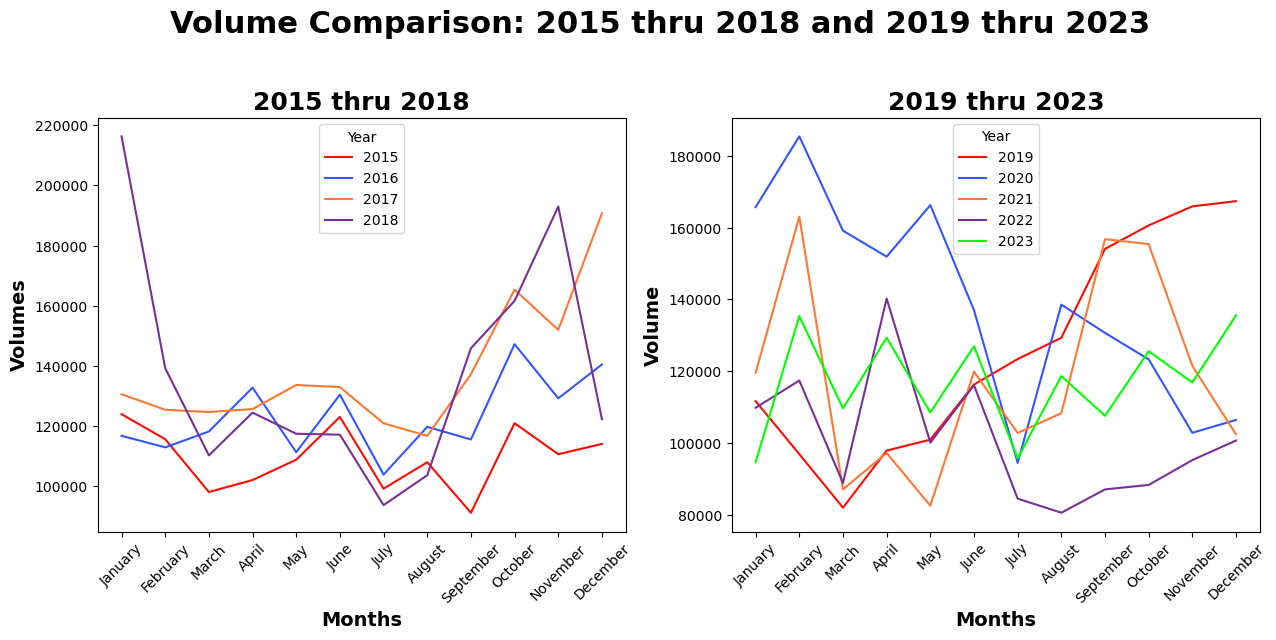

In [13]:
# Side by side view of volumes
plt.figure(figsize=(15,6))

# 1st 4 years of volumes
plt.subplot(121)
vs_lp1 = sns.lineplot(x='Month Name', y='Volume',  hue='Year',
             data = ng_dfv.loc[(ng_dfv['Year'] >= 2015) & (ng_dfv['Year'] < 2019)].sort_values(by = 'Price Date'),
                     ci = None,
                     palette = more_colors)

vs_lp1.set_title('2015 thru 2018', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vs_lp1.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vs_lp1.set_ylabel('Volumes', fontdict={'size': 14, 'weight': 'bold'})
plt.xticks(rotation = 45)

# 2nd 5 years of volumes
plt.subplot(122)
vs_lp1 = sns.lineplot(x='Month Name', y='Volume',  hue='Year',
             data = ng_dfv.loc[(ng_dfv['Year'] >= 2019) & (ng_dfv['Year'] < 2024)].sort_values(by='Price Date'),
                     ci = None,
                     palette = more_colors)

vs_lp1.set_title('2019 thru 2023', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vs_lp1.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vs_lp1.set_ylabel('Volume', fontdict={'size': 14, 'weight': 'bold'})
#Set x-axis labels bold
plt.xticks(rotation = 45)

plt.suptitle('Volume Comparison: 2015 thru 2018 and 2019 thru 2023', 
             fontsize = 22, weight = 'extra bold')
plt.subplots_adjust(top=0.8)
plt.show()

In [14]:
# Create Winter Dataframe (Dec, Jan, Feb)

winter_only = ng_dfv.loc[(ng_dfv['Season'] == 'Winter') & 
                   (ng_dfv['Year'] >= 2018) & (ng_dfv['Year'] <= 2023)]
winter_only = winter_only[['Month Name','Year','Close','Volume']]

winter_only_df = winter_only.join(winter_df.set_index(['Month Name','Year']), 
                                  on = ['Month Name','Year'],
                                 lsuffix = '_prices', rsuffix = '_season')
winter_only_df.dropna(subset=['sort_order'], inplace=True)
winter_only_df['Season Year'] = winter_only_df['Season Year'].astype('int')

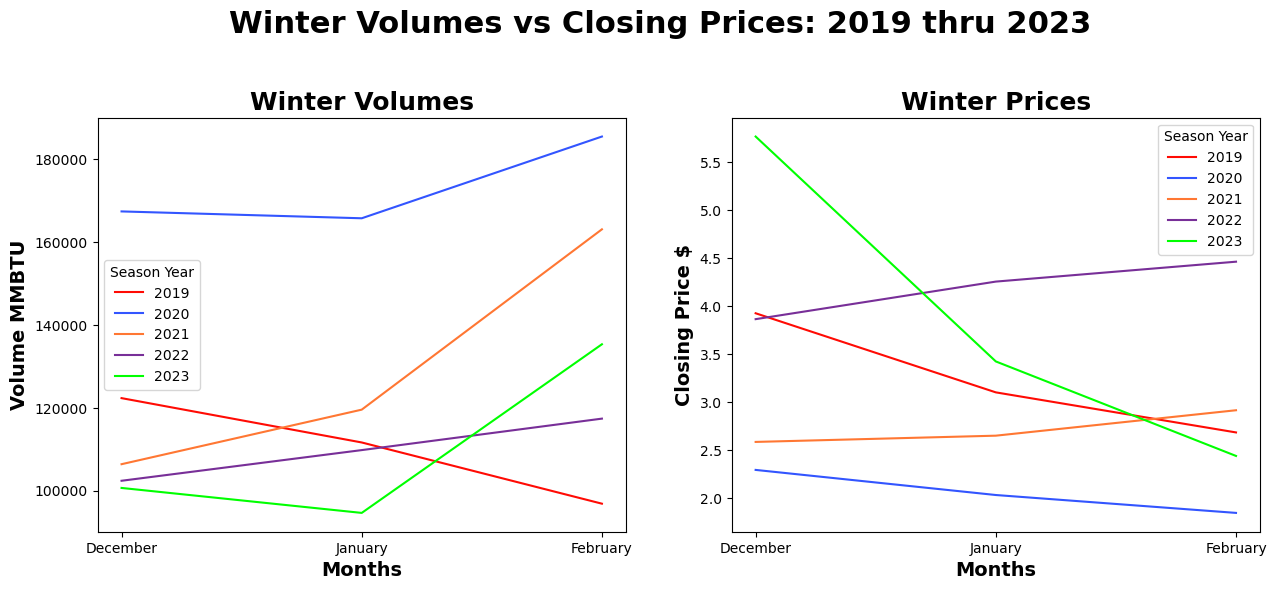

In [15]:
# Side by side view of Winter Prices vs Volumes
plt.figure(figsize=(15,6))

# Winter Volumes
plt.subplot(121)
vw_lp = sns.lineplot(x = 'Month Name', y = 'Volume', hue = 'Season Year', 
             data = winter_only_df.loc[(winter_only_df['Season Year'] >= 2019) & 
                            (winter_only_df['Season Year'] <= 2023)].sort_values(by='sort_order'),
                     ci = None, 
                     palette = more_colors)

vw_lp.set_title('Winter Volumes', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vw_lp.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vw_lp.set_ylabel('Volume MMBTU', fontdict={'size': 14, 'weight': 'bold'})

# Winter Prices
plt.subplot(122)
vw_lp = sns.lineplot(x='Month Name', y = 'Close', hue = 'Season Year', 
             data = winter_only_df.loc[(winter_only_df['Season Year'] >= 2019) & 
                            (winter_only_df['Season Year'] <= 2023)].sort_values(by='sort_order'),
                     ci = None, 
                     palette = more_colors)

vw_lp.set_title('Winter Prices', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vw_lp.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vw_lp.set_ylabel('Closing Price $', fontdict={'size': 14, 'weight': 'bold'})

plt.suptitle('Winter Volumes vs Closing Prices: 2019 thru 2023', 
             fontsize = 22, weight = 'extra bold')
plt.subplots_adjust(top=0.8)
plt.show()

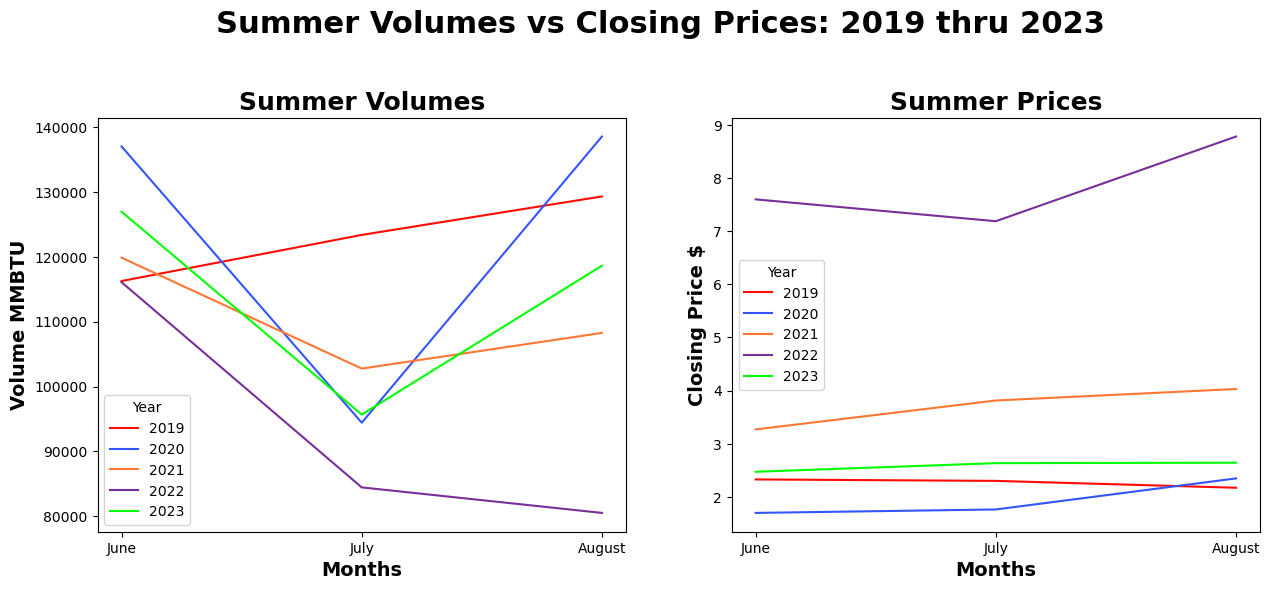

In [16]:
# Side by side view of Summer Prices vs Volumes
plt.figure(figsize=(15,6))

# Summer Volumes
plt.subplot(121)
vs_lp = sns.lineplot(x='Month Name', y='Volume', hue='Year', 
             data = ng_dfv.loc[(ng_dfv['Season'] == 'Summer') & 
                    (ng_dfv['Year'] >= 2019) & (ng_dfv['Year'] < 2024)].sort_values(by='Price Date'),
                     ci = None,
                     palette = more_colors)

vs_lp.set_title('Summer Volumes', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vs_lp.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vs_lp.set_ylabel('Volume MMBTU', fontdict={'size': 14, 'weight': 'bold'})

# Summer Prices
plt.subplot(122)
vs_lp = sns.lineplot(x='Month Name', y = 'Close', hue='Year', 
             data = ng_dfv.loc[(ng_dfv['Season'] == 'Summer') & 
                    (ng_dfv['Year'] >= 2019) & (ng_dfv['Year'] < 2024)].sort_values(by='Price Date'),
                     ci = None,
                     palette = more_colors)

vs_lp.set_title('Summer Prices', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
vs_lp.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
vs_lp.set_ylabel('Closing Price $', fontdict={'size': 14, 'weight': 'bold'})

plt.suptitle('Summer Volumes vs Closing Prices: 2019 thru 2023', 
             fontsize = 22, weight = 'extra bold')
plt.subplots_adjust(top=0.8)
plt.show()

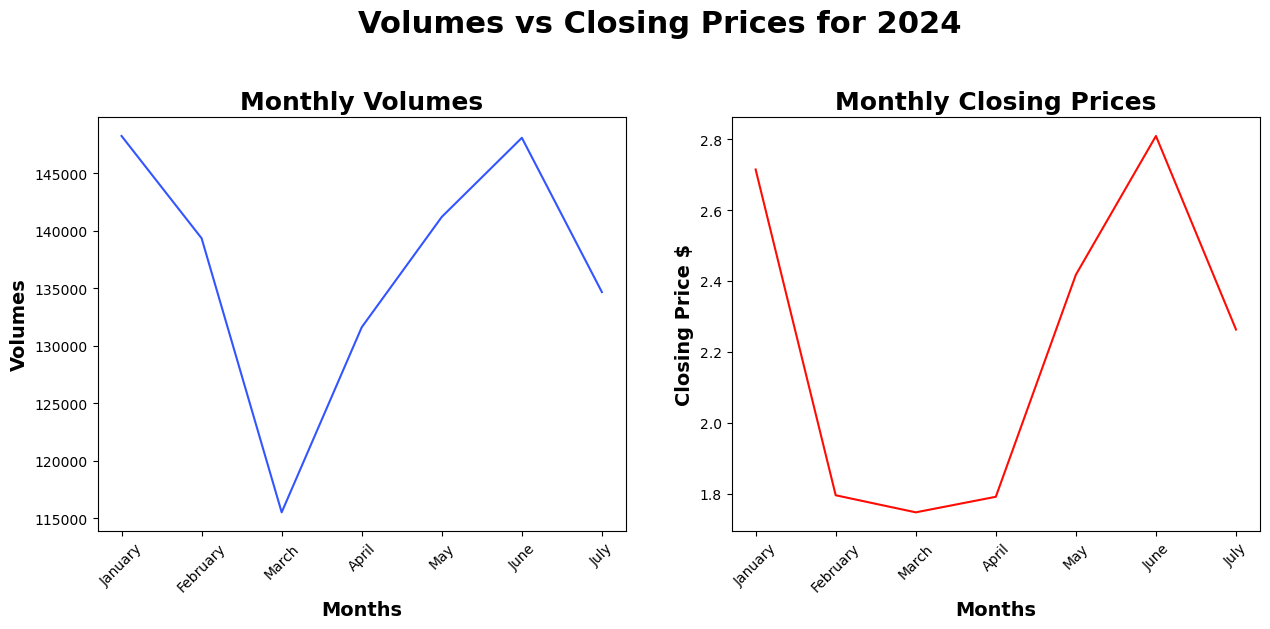

In [17]:
# Side by side view of volumes and prices
plt.figure(figsize=(15,6))

# 2024 Volumes
plt.subplot(121)
p2024_lp1 = sns.lineplot(x='Month Name', y='Volume',  
             data = ng_dfv.loc[(ng_dfv['Year'] == 2024)].sort_values(by='Price Date'),
                     ci = None,
                     color = blue)

p2024_lp1.set_title('Monthly Volumes', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
p2024_lp1.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
p2024_lp1.set_ylabel('Volumes', fontdict={'size': 14, 'weight': 'bold'})
plt.xticks(rotation = 45)

# 2024 prices
plt.subplot(122)
p2024_lp2 = sns.lineplot(x='Month Name', y='Close',  
             data = ng_dfv.loc[(ng_dfv['Year'] == 2024)].sort_values(by='Price Date'),
                     ci = None, color = red)

p2024_lp2.set_title('Monthly Closing Prices', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
p2024_lp2.set_xlabel('Months', fontdict={'size': 14, 'weight': 'bold'})
p2024_lp2.set_ylabel('Closing Price $', fontdict={'size': 14, 'weight': 'bold'})
#Set x-axis labels bold
plt.xticks(rotation = 45)

plt.suptitle('Volumes vs Closing Prices for 2024', 
             fontsize = 22, weight = 'extra bold')
plt.subplots_adjust(top=0.8)
plt.show()

In [18]:
# Explore Autoregressive integrated moving average (Arima)

# Set Price Date as index
ng_df.set_index('Price Date', inplace=True)

# Create ARIMA model for residuals
ARIMA_model_res = ARIMA(ng_df['Close'], order=(5,1,0))
ARIMA_fit_res = ARIMA_model_res.fit()

# ARIMA fit model summary
print(ARIMA_fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2529
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1092.767
Date:                Sat, 10 Aug 2024   AIC                          -2173.534
Time:                        19:20:45   BIC                          -2138.523
Sample:                             0   HQIC                         -2160.831
                               - 2529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1114      0.008    -14.139      0.000      -0.127      -0.096
ar.L2         -0.0260      0.011     -2.286      0.022      -0.048      -0.004
ar.L3          0.0290      0.010      2.943      0.0

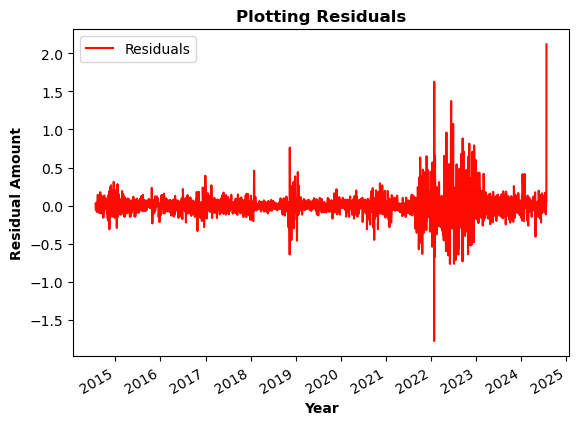

In [19]:
# Plot residuals
resid_df = pd.DataFrame(ARIMA_fit_res.resid)

# Change 0 column header to Residuals
new_col_headers = {0: 'Residuals'}
resid_df.rename(columns = new_col_headers, inplace = True)

# Plot Residuals

resid_df.plot()
plt.title("Plotting Residuals", fontsize='large', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Residual Amount', fontweight='bold')

plt.show()

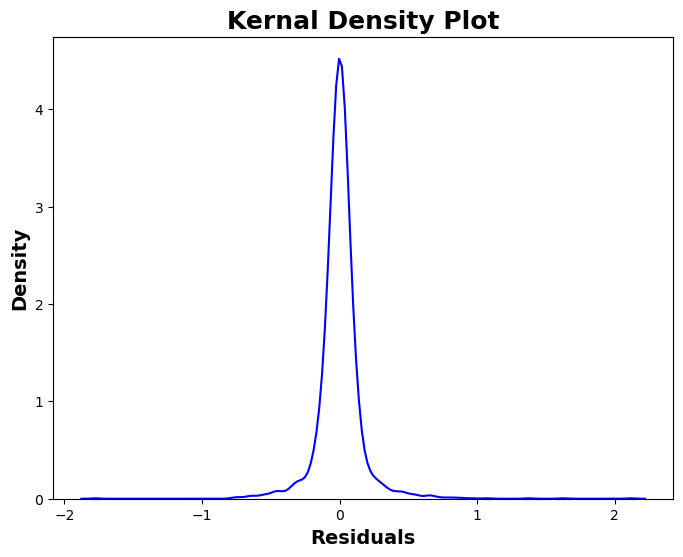

In [20]:
# Create residuals density plot

fig, axes = plt.subplots(figsize = (8, 6))

kde_plt = sns.kdeplot(data = resid_df, x = 'Residuals', color = 'blue')
kde_plt.set_title('Kernal Density Plot', 
                      fontdict={'size': 18, 'weight': 'bold', 'color': 'black'})
kde_plt.set_xlabel('Residuals', fontdict={'size': 14, 'weight': 'bold'})
kde_plt.set_ylabel('Density', fontdict={'size': 14, 'weight': 'bold'})

plt.show()

In [21]:
# Residuals Summary
print(resid_df.describe())

         Residuals
count  2529.000000
mean      0.001579
std       0.162586
min      -1.775629
25%      -0.055410
50%       0.000479
75%       0.053380
max       2.117000


Test RMSE: 0.080
Test MAPE: 0.022


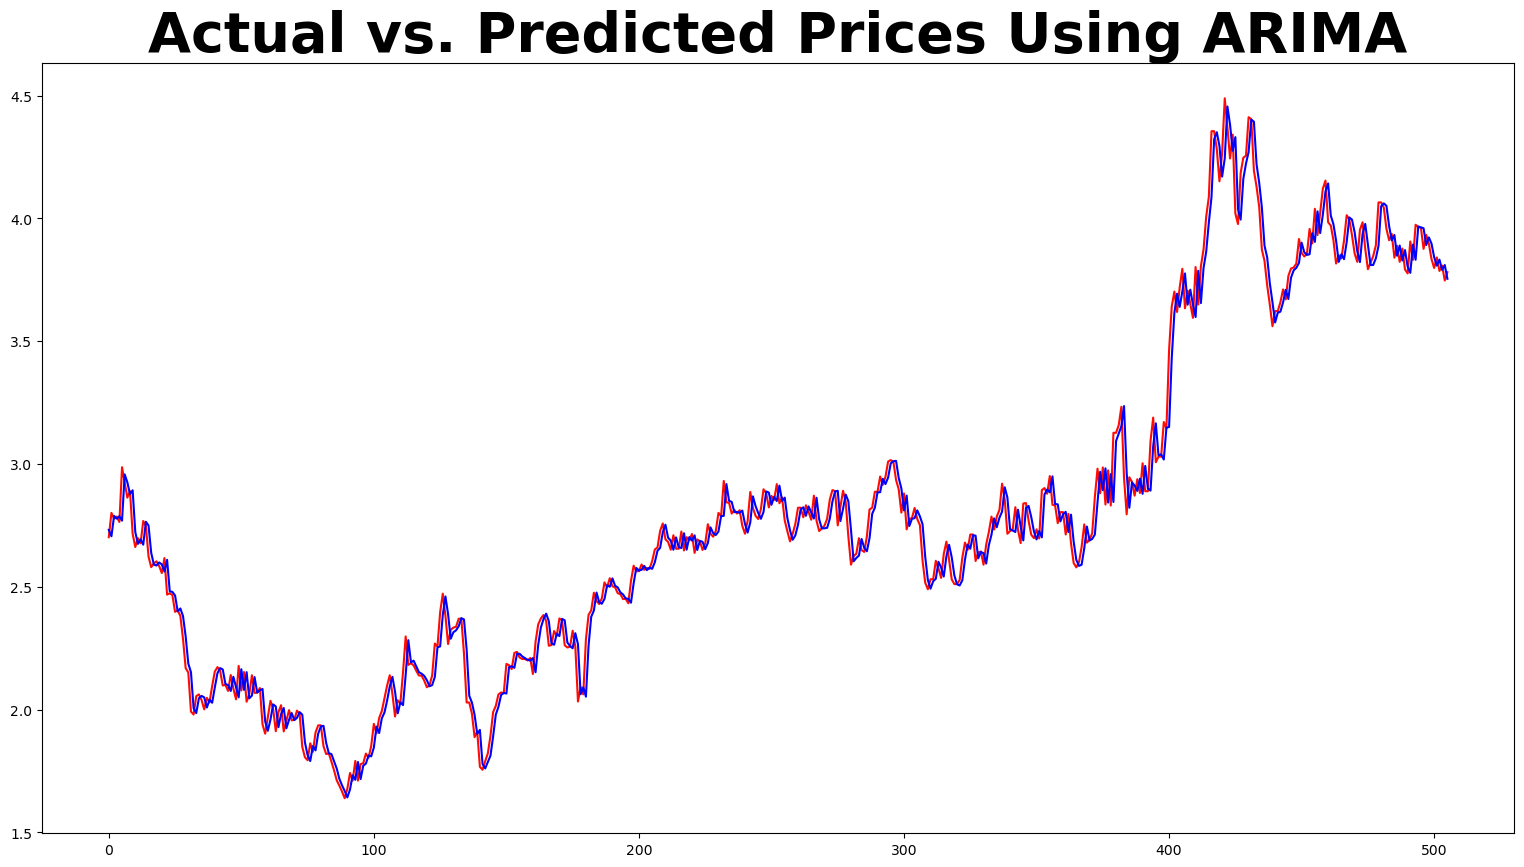

In [22]:
# Forecast Future Prices using Autoregressive 
# integrated moving average (Arima)

prices = ng_df['Close']
prices.index = ng_df['Close'].index

# split into train and test sets
X = prices.values
split = int(len(X) * 0.80)
train, test = X[0:split], X[split:len(X)]
prior_prices = [x for x in train]
ARIMA_preds = list()

# walk-forward validation
for i in range(len(test)):
    ARIMA_model = ARIMA(prior_prices, order=(5,1,0))
    ARIMA_model_fit = ARIMA_model.fit()
    output = ARIMA_model_fit.forecast()
    yhat = output[0]
    ARIMA_preds.append(yhat)
    obs = test[i]
    prior_prices.append(obs)

#print('predicted = %f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, ARIMA_preds))
print('Test RMSE: %.3f' % rmse)

mape = np.mean(np.abs(ARIMA_preds - test)/np.abs(test))
print('Test MAPE: %.3f' % mape)

# plot forecasts against actual outcomes
fig, axes = plt.subplots(figsize = (19, 10))
plt.plot(test)
plt.plot(ARIMA_preds, color='blue')
plt.title("Actual vs. Predicted Prices Using ARIMA", fontweight='bold', fontsize = 40)
plt.show()

In [23]:
# Create Future Prices with Prophet

# Create the prophet Model
prophet_df = pd.DataFrame(ng_df.index, ng_df['Close'])
prophet_df.reset_index(inplace=True)
prophet_df.rename(columns={'Price Date': 'ds', 'Close': 'y'}, inplace=True)

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods = 120)
future.tail()


19:22:42 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing


,ds
2644,2024-11-17
2645,2024-11-18
2646,2024-11-19
2647,2024-11-20
2648,2024-11-21


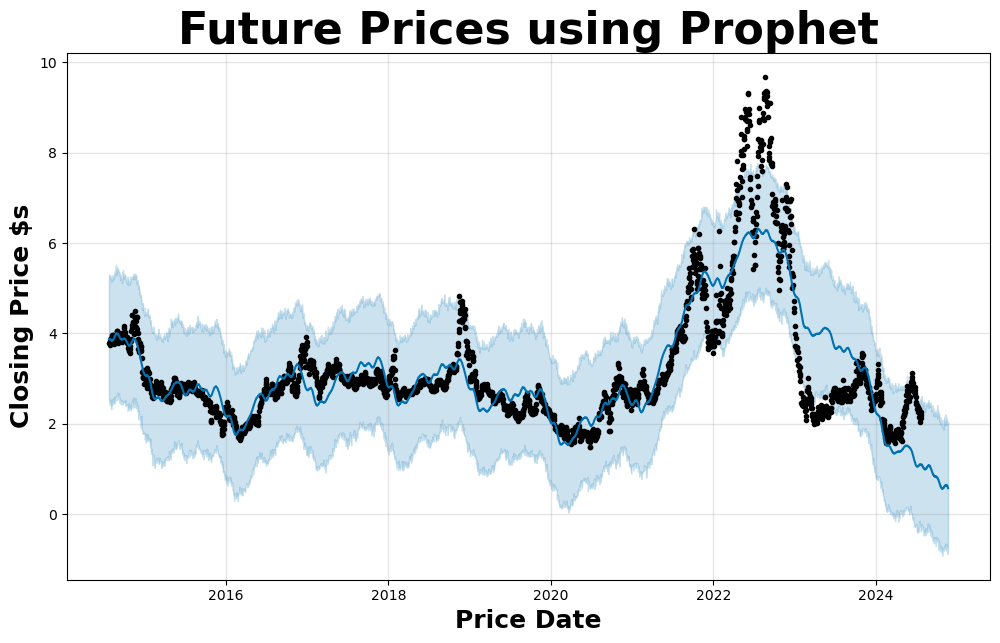

In [24]:
# Forecast 120 days in the future

forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
prophet_model.plot(forecast)
plt.title("Future Prices using Prophet", fontweight='bold', fontsize = 32)
plt.xlabel("Price Date", fontweight='bold', fontsize = 18)
plt.ylabel("Closing Price $s", fontweight='bold', fontsize = 18)
plt.show()

19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing


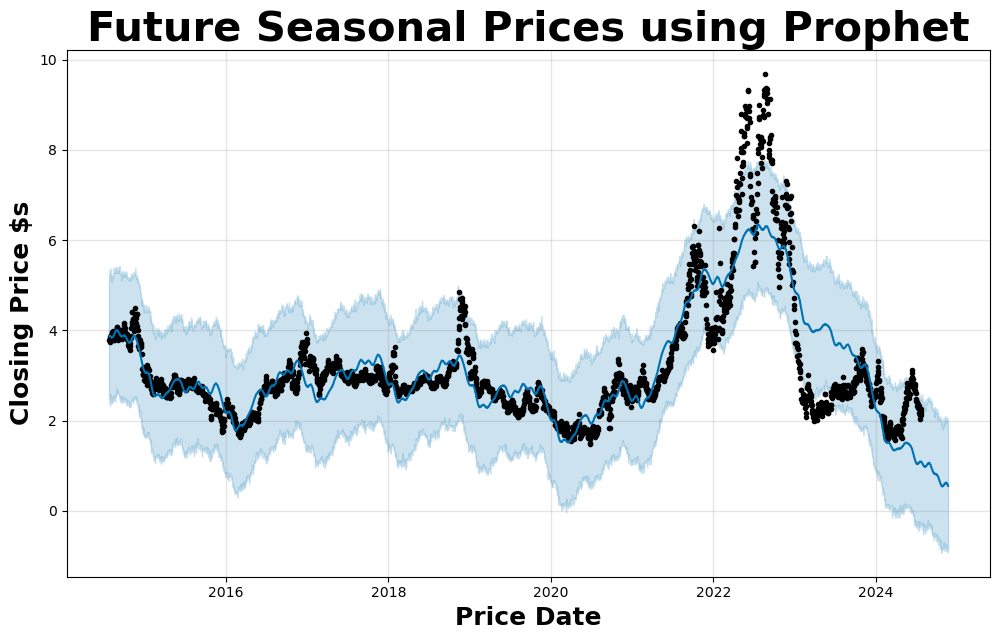

In [25]:
# Add Seasonality to Profit

prophet_df.reset_index(inplace=True)

seasonal_model = Prophet(daily_seasonality=True, interval_width=0.95)
seasonal_model.fit(prophet_df)

# Create future dataframe and make predictions
future = seasonal_model.make_future_dataframe(periods=120)
forecast = seasonal_model.predict(future)

# Plot predictions
seasonal_model.plot(forecast)
plt.title("Future Seasonal Prices using Prophet", fontweight='bold', fontsize = 30)
plt.xlabel("Price Date", fontweight='bold', fontsize = 18)
plt.ylabel("Closing Price $s", fontweight='bold', fontsize = 18)
plt.show()

In [26]:
print('The End')

The End
